# PII Masking : Data Preparation and Analysis

## Objective
This notebook prepares and analyzes a dataset for training a model to detect and mask Personally Identifiable Information (PII), specifically names and email addresses. The dataset used is a subset of the WikiNeural dataset, which is enriched with synthetic email addresses if they are not already present.

## Steps
1. **Data Loading**: Load the dataset from Google Drive.
2. **Data Inspection**: Analyze the dataset to understand its structure, NER tag distribution, and sequence lengths.
3. **Synthetic Email Generation**: Inject synthetic email addresses into the dataset to ensure a realistic distribution of PII.
4. **Data Splitting**: Split the dataset into training, validation, and test sets.
5. **Data Saving**: Save the processed datasets for future use.


In [1]:
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install seqeval
!pip install gdown
!pip install pandas scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Import Required Libraries
This cell imports the necessary Python libraries for data manipulation, analysis, and visualization.
- `pandas`: For data manipulation.
- `train_test_split`: For splitting the dataset.
- `random`: For generating synthetic email addresses.
- `gdown`: For downloading files from Google Drive.
- `ast`: For safely evaluating strings as Python expressions.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import gdown
import ast

### Mount Google Drive

Mount your google drive to save the datasets, model over the drive.

Note: If you want to run the code locally, update the file paths accordingly for loading and saving datasets and models.
The commented path are for the local storage. Adjust them according to your need

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download Dataset from Google Drive
This cell downloads the dataset (`data.json`) from Google Drive using the `gdown` library. The dataset is then loaded into a Pandas DataFrame for further processing.

In [4]:
# https://drive.google.com/file/d/1pmYdpJHdaYuPnG1PvPGND-7KABtRHPi9/view?usp=sharing
data_file_id ="1pmYdpJHdaYuPnG1PvPGND-7KABtRHPi9"

gdown.download(f"https://drive.google.com/uc?id={data_file_id}", "data.json", quiet=False)
data = pd.read_json('data.json')
print(data.head())


Downloading...
From: https://drive.google.com/uc?id=1pmYdpJHdaYuPnG1PvPGND-7KABtRHPi9
To: /content/data.json
100%|██████████| 34.0M/34.0M [00:00<00:00, 54.8MB/s]


  lang                                           ner_tags  \
0   en  [O, O, O, O, B-PER, I-PER, O, O, O, O, B-PER, ...   
1   en  [O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O...   
2   en                 [O, O, O, O, O, O, O, O, B-PER, O]   
3   en  [O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O,...   
4   en  [O, O, O, O, B-PER, I-PER, I-PER, O, O, O, O, ...   

                                            sequence  \
0  Since then , only Terry Bradshaw in 147 games ...   
1  He was portrayed by Anthony Perkins in the 196...   
2  The egg eventually hatches , revealing a baby ...   
3  In the video Kelis is walking down a street in...   
4  According to food writer Sharon Tyler Herbst ,...   

                                              tokens  
0  [Since, then, ,, only, Terry, Bradshaw, in, 14...  
1  [He, was, portrayed, by, Anthony, Perkins, in,...  
2  [The, egg, eventually, hatches, ,, revealing, ...  
3  [In, the, video, Kelis, is, walking, down, a, ...  
4  [According, to, fo

### Dataset Inspection and Analysis

This section focuses on inspecting and analyzing the dataset to understand its structure, content, and distribution of Named Entity Recognition (NER) tags. The following steps are performed:

1. **Dataset Overview**:
   - The first few rows of the dataset are displayed to provide a snapshot of its structure.
   - The columns and their data types are listed to understand the schema of the dataset.
   - Missing values are checked to ensure data quality.

2. **NER Tag Analysis**:
   - The frequency of each NER tag is counted to understand the distribution of entity types (e.g., names, email addresses).
   - The most common and rare NER tags are identified, which helps in understanding the dataset's balance and potential biases.

3. **Token Analysis**:
   - Sample tokens from the dataset are displayed to provide insights into the tokenized text data.

4. **Visualization**:
   - A bar plot is created to visualize the distribution of NER tags, highlighting the most common and rare tags.
   - A histogram is generated to visualize the distribution of


In [ ]:
print("Columns in the dataset:", data.columns)
print("\nData types:\n", data.dtypes)

Columns in the dataset: Index(['lang', 'ner_tags', 'sequence', 'tokens'], dtype='object')

Data types:
 lang        object
ner_tags    object
sequence    object
tokens      object
dtype: object


In [ ]:
from collections import Counter

all_ner_tags = [tag for sublist in data["ner_tags"] for tag in sublist]

ner_tag_counts = Counter(all_ner_tags)
print("Frequency of NER tags:")
print(ner_tag_counts)

Frequency of NER tags:
Counter({'O': 639055, 'B-PER': 40264, 'I-PER': 29466})


In [ ]:
print("Sample tokens:")
print(data["tokens"].head())

Sample tokens:
0    [Since, then, ,, only, Terry, Bradshaw, in, 14...
1    [He, was, portrayed, by, Anthony, Perkins, in,...
2    [The, egg, eventually, hatches, ,, revealing, ...
3    [In, the, video, Kelis, is, walking, down, a, ...
4    [According, to, food, writer, Sharon, Tyler, H...
Name: tokens, dtype: object


In [ ]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
lang        0
ner_tags    0
sequence    0
tokens      0
dtype: int64


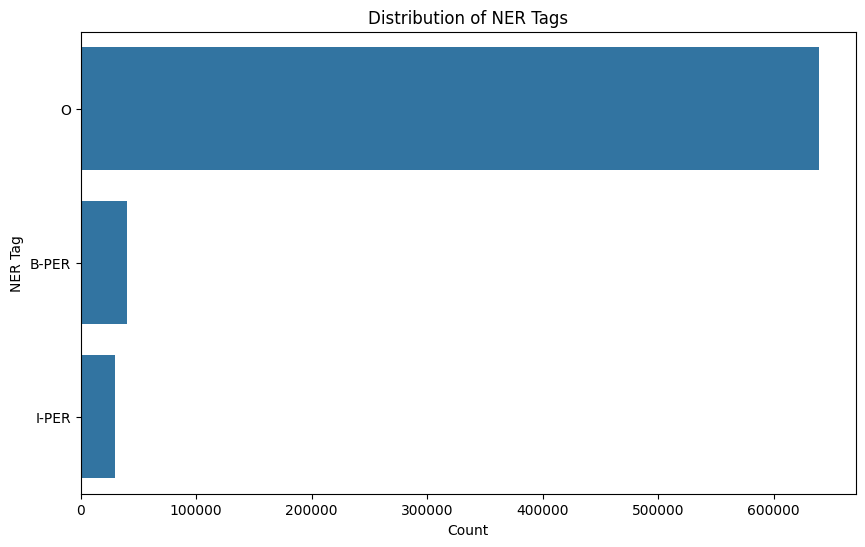

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(y=all_ner_tags, order=[tag for tag, _ in ner_tag_counts.most_common()])
plt.title("Distribution of NER Tags")
plt.xlabel("Count")
plt.ylabel("NER Tag")
plt.show()

### Generate Synthetic Emails
This cell defines a function to generate synthetic email addresses using a combination of names and random domains. The function ensures that the generated emails are realistic.

In [5]:
def generate_email(name):
    domains = ["gmail.com", "yahoo.com", "outlook.com", "fastnu.edu.pk"]
    formatted_name = name.lower().replace(" ", ".")
    return f"{formatted_name}{random.randint(10, 99)}@{random.choice(domains)}"


### Apply Email Injection
This cell applies the `append_emails` function to the entire dataset, enriching it with synthetic email addresses. The modified dataset is then saved to a CSV file for future use.

In [6]:
def append_emails(data, email_probability=0.05):
    sequence = data["sequence"]
    tokens = data["tokens"]
    ner_tags = data["ner_tags"]

    for i, token in enumerate(tokens):
        if ner_tags[i] == "B-PER":
            name = token.lower()

            if i + 1 < len(tokens) and ner_tags[i + 1] == "I-PER":
                name += "." + tokens[i + 1].lower()
                i += 1

            email = generate_email(name)
            email_tokens = email.split("@")[0].split(".") + ["@", email.split("@")[1]]

            tokens.extend(email_tokens)
            ner_tags.extend(["B-EMAIL"] + ["I-EMAIL"] * (len(email_tokens) - 1))

            sequence += f" {email}"

    data["sequence"] = sequence
    data["tokens"] = tokens
    data["ner_tags"] = ner_tags
    return data


In [7]:
data = data.apply(append_emails, axis=1)
data.to_csv("/content/drive/MyDrive/NoteBook/synthetic_data.csv", index=False)
data.to_csv("synthetic_data.csv", index=False)

### Load Modified Dataset
This cell loads the modified dataset (with synthetic emails) from the CSV file and displays the first few rows to verify the changes.

In [8]:
data = pd.read_csv("/content/drive/MyDrive/NoteBook/synthetic_data.csv")
# data = pd.read_csv("synthetic_data.csv")
print(data.head()['tokens'][0])

['Since', 'then', ',', 'only', 'Terry', 'Bradshaw', 'in', '147', 'games', ',', 'Joe', 'Montana', 'in', '139', 'games', ',', 'and', 'Tom', 'Brady', 'in', '131', 'games', 'have', 'reached', '100', 'wins', 'more', 'quickly', '.', 'terry', 'bradshaw25', '@', 'yahoo.com', 'joe', 'montana28', '@', 'outlook.com', 'tom', 'brady22', '@', 'yahoo.com']


### Save Dataset Splits
This cell saves the training, validation, and test sets to CSV files. These files will be used for model training and evaluation.

In [ ]:
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_data.to_csv("/content/drive/MyDrive/NoteBook/train.csv", index=False)
val_data.to_csv("/content/drive/MyDrive/NoteBook/val.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/NoteBook/test.csv", index=False)
# train_data.to_csv("train.csv", index=False)
# val_data.to_csv("val.csv", index=False)
# test_data.to_csv("test.csv", index=False)



### Download and Prepare Test Data
This cell downloads a test dataset from Google Drive using `gdown`. The dataset is saved as a JSON file (`test_data.json`). After downloading, the dataset is loaded into a Pandas DataFrame. A function (`append_emails`) is applied to the dataset to add or modify email-related data. Finally, the processed dataset is saved as a CSV file (`synthetic_test_data.csv`) for further use. The first few rows of the dataset are printed to verify the data.

In [ ]:
# https://drive.google.com/file/d/1pmYdpJHdaYuPnG1PvPGND-7KABtRHPi9/view?usp=sharing
test_data_file_id ="1E2FjYFDGEeXTwpabkC0aYzZV8aOQqf_h"

gdown.download(f"https://drive.google.com/uc?id={test_data_file_id}", "test_data.json", quiet=False)
test_data = pd.read_json('test_data.json')

Downloading...
From: https://drive.google.com/uc?id=1E2FjYFDGEeXTwpabkC0aYzZV8aOQqf_h
To: /content/test_data.json
100%|██████████| 4.19M/4.19M [00:00<00:00, 95.8MB/s]


In [ ]:
test_data = test_data.apply(append_emails, axis=1)
data.to_csv("/content/drive/MyDrive/NoteBook/synthetic_test_data.csv", index=False)
# data.to_csv("synthetic_test_data.csv", index=False)

In [ ]:
print(test_data.head())

  lang                                           ner_tags  \
0   en  [O, O, O, O, O, O, O, O, O, B-PER, I-PER, O, B...   
1   en  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
2   en  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
3   en  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
4   en  [O, O, O, O, O, O, O, B-PER, I-PER, O, B-EMAIL...   

                                            sequence  \
0  included future Rage Against the Machine and A...   
1  The city voted 53.5 percent in favor of the ma...   
2  It was not until about 1907 – 1909 that he pro...   
3  Always in his bowler hat , he was a witty pres...   
4  The music was composed and conducted by Ronald...   

                                              tokens  
0  [included, future, Rage, Against, the, Machine...  
1  [The, city, voted, 53.5, percent, in, favor, o...  
2  [It, was, not, until, about, 1907, –, 1909, th...  
3  [Always, in, his, bowler, hat, ,, he, was, a, ...  
4  [The, music, was, 